<a href="https://colab.research.google.com/github/cjdolan/HighResolutionSemanticClassification/blob/main/RemoteSensingObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

R-CNN Notebook
Author: Connor Dolan

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 38.4 MB/s eta 0:00:00


In [ ]:
!pip install -U pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.18 requires requests>=2.26, but you have requests 2.25.1 which is incompatible.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.
google-colab 1.0.0 requires requests>=2.27.0, but you have requests 2.25.1 which is incompatible.
d2l 0.17.6 requires pandas==1.2.4, but you have pandas 2.0.1 which is incompatible.


In [ ]:
import pandas as pd
import requests
from collections import defaultdict
import time
from tqdm import tqdm
from urllib.parse import urljoin
from shapely.geometry import Polygon
import numpy as np
from multiprocessing.pool import ThreadPool
import zipfile
from glob import glob
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
import os
import shutil
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
import rasterio
from ast import literal_eval
import cv2
from tqdm.notebook import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ATML_Dataset_Largest.csv')
df.head(11)

,Unnamed: 0,fileName,bbox,Class,entity_id,product_id
0,0,M_2509704_SE_14_1_20161206,"[[5739, 3030, 6048, 3297]]",['stadium'],2312564.0,5e83a340275f0f2c
1,1,M_2608101_SW_17_1_20171031,"[[78, 917, 2610, 3698]]",['airport'],2545525.0,5e83a340275f0f2c
2,2,M_2608126_NW_17_1_20171104,"[[663, 3805, 2246, 5478]]",['airport'],2545553.0,5e83a340275f0f2c
3,3,M_2608127_SW_17_1_20171104,"[[-2330, 1771, 1696, 5332]]",['airport'],2545403.0,5e83a340275f0f2c
4,4,M_2608214_NE_17_1_20171031,"[[5511, 1748, 7297, 3539]]",['airport'],2545600.0,5e83a340275f0f2c
5,5,M_2608224_SW_17_1_20171104,"[[1125, 4639, 1742, 4732]]",['airport'],2545626.0,5e83a340275f0f2c
6,6,M_2609741_SW_14_1_20161010,"[[2187, 1648, 2326, 1878]]",['stadium'],2312716.0,5e83a340275f0f2c
7,7,M_2609751_NE_14_1_20161115,"[[925, 6516, 1039, 6699]]",['stadium'],2312588.0,5e83a340275f0f2c
8,8,M_2609847_NE_14_1_20161010,"[[1427, 7184, 1620, 7379], [1410, 7146, 1838, ...","['stadium', 'stadium']",2312939.0,5e83a340275f0f2c
9,9,M_2609847_SE_14_1_20161010,"[[1400, 4858, 1463, 4968], [5469, 3548, 5677, ...","['stadium', 'stadium', 'stadium']",2312941.0,5e83a340275f0f2c


In [ ]:
df['bbox'] = df['bbox'].apply(lambda x: literal_eval(x))
df['Class'] = df['Class'].apply(lambda x: literal_eval(x))

In [ ]:
def correct_bbox(fileName, bbox):
  new_bbox = []
  try:
    with rasterio.open('/content/drive/MyDrive/ATMLData/atml_bucket/' + fileName.lower() + '.tif') as img:
      for box in bbox:
        new_box = []
        y_old = img.shape[0]
        x_old = img.shape[1]

        for i in range(4):
          old = None
          if i % 2 == 0:
            old = x_old
          else:
            old = y_old
          new_val = int((float(box[i]) / float(old)) * 1500)
          if new_val < 0:
            new_val = 0
          elif new_val > 1500:
            new_val = 1500
          new_box.append(new_val)


        new_bbox.append(new_box)
  except:
    pass
  return new_bbox

print(correct_bbox(df.at[4, 'fileName'], df.at[8, 'bbox']))

NameError: ignored

In [ ]:
tqdm.pandas()

In [ ]:
df['bbox'] = df[['fileName', 'bbox']].progress_apply(lambda x: correct_bbox(x.fileName, x.bbox), axis=1)

  0%|          | 0/2152 [00:00<?, ?it/s]

In [ ]:
df.to_csv('/content/drive/MyDrive/ATML_Dataset_1500.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ATML_Dataset_1500.csv')
df['bbox'] = df['bbox'].apply(lambda x: literal_eval(x))
df['Class'] = df['Class'].apply(lambda x: literal_eval(x))
encodings = {'airport':0, 'stadium':1, 'power_plant':2}

df['Label'] = df['Class'].apply(lambda x: [encodings[y] for y in x])

In [ ]:
new_df = pd.DataFrame(columns=df.columns)
idx = 0
for index, row in tqdm(df.iterrows(), position=0, leave=True):
  if len(row.bbox) > 0:
    new_df.at[idx, 'fileName'] = row.fileName
    new_df.at[idx, 'bbox'] = row.bbox
    new_df.at[idx, 'Class'] = row.Class
    new_df.at[idx, 'Label'] = row.Label
    idx += 1
df = new_df

0it [00:00, ?it/s]

In [ ]:
IMG_DIR = '/content/drive/MyDrive/NAIP_Lower_Res_1500_v3/'

In [ ]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.2 MB/s eta 0:00:00
  Created wheel for pandas: filename=panda

In [ ]:
from d2l import torch as d2l

def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

In [ ]:
idx = 60

img = cv2.imread(IMG_DIR + df.at[idx, 'fileName'].lower() + '.png')[905:946,502:527]

fig, ax = plt.subplots()

# Display the image
ax.imshow(img)
ax.add_patch(bbox_to_rect(df.at[idx, 'bbox'][0], 'blue'))

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
def overlap(rect1,rect2):
  try:
    p1 = Polygon([[rect1[0], rect1[1]], [rect1[2],rect1[1]],
                  [rect1[0], rect1[3]], [rect1[2], rect1[3]]])
    p2 = Polygon([[rect2[0], rect2[1]], [rect2[2],rect2[1]],
                  [rect2[0], rect2[3]], [rect2[2], rect2[3]]])
    return(p1.intersects(p2))
  except:
    return False

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [ ]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.15.1

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 42759b1cc8 Version number bump for vision (#7419)


In [ ]:
import transforms as T


def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
      transforms.append(T.RandomHorizontalFlip(0.5))
    return Compose(transforms)

In [ ]:
from PIL import Image

In [ ]:
class RemoteDataset(Dataset):
  def __init__(self, fileNames, bboxes, classes, transformations=None, validation=False):
    self.images = []
    self.targets = []
    self.bboxes = bboxes
    self.classes = classes
    self.validation = validation
    self.transforms = transformations
    if not validation:
      for f in tqdm(fileNames, position=0, leave=True):
        try:
          img = cv2.imread(IMG_DIR + f.lower() + '.png') / 255.0
          self.images.append(img)
        except:
          continue
    else:
      for i,f in tqdm(enumerate(fileNames), position=0, leave=True):
        try:
          img = cv2.imread(IMG_DIR + f.lower() + '.png') / 255.0
          bboxes = self.bboxes[i]
          bbox = bboxes[0]
          label = self.classes[i]

          final_boxes = []
          final_classes = []

          if bbox[0] < (1500-bbox[2]):
            start_x = random.randint(0, min(bbox[0], 860))
            while start_x + 640 < bbox[2]:
              start_x += 100
            end_x = start_x + 640
            x1 = bbox[0] - start_x
            x2 = bbox[2] - start_x
          else:
            end_x = random.randint(max(bbox[2], 640), 1500)
            while end_x - 640 > bbox[0]:
              end_x -= 100
            start_x = end_x - 640
            x1 = bbox[0] - start_x
            x2 = bbox[2] - start_x
          if bbox[1] < (1500-bbox[3]):
            start_y = random.randint(0, min(bbox[1], 860))
            while start_y + 640 < bbox[3]:
              start_y += 100
            end_y = start_y + 640
            y1 = bbox[1] - start_y
            y2 = bbox[3] - start_y
          else:
            end_y = random.randint(max(bbox[3], 640), 1500)
            while end_y - 640 > bbox[1]:
              end_y -= 100
            start_y = end_y - 640
            y1 = bbox[1] - start_y
            y2 = bbox[3] - start_y

          img = img[start_y:end_y,start_x:end_x,:]

          for i, b in enumerate(bboxes):
            new_b = [0.0,0.0,0.0,0.0]
            new_b[0] = max(b[0] - start_x, 0)
            new_b[1] = min(b[1] - start_y, 640)
            new_b[2] = max(b[2] - start_x, 0)
            new_b[3] = min(b[3] - start_y, 640)
            if overlap(b, [start_x, start_y, end_x, end_y]) and new_b[0] < new_b[2] and new_b[1] < new_b[3]:
              final_boxes.append([p for p in new_b])
              final_classes.append(label[i]+1)
          if len(final_boxes) == 0:
            final_boxes = torch.zeros((0, 4), dtype=torch.float32)
            final_classes.append(0)
          else:
            # bounding box to tensor
            final_boxes = torch.as_tensor(final_boxes, dtype=torch.float32)
          # area of the bounding boxes
          area = (final_boxes[:, 3] - final_boxes[:, 1]) * (final_boxes[:, 2] - final_boxes[:, 0])
          # no crowd instances
          iscrowd = torch.zeros((final_boxes.shape[0],), dtype=torch.int64)
          # labels to tensor
          final_classes = torch.as_tensor(final_classes, dtype=torch.int64)
          # prepare the final `target` dictionary
          target = {}
          target["boxes"] = final_boxes
          target["labels"] = final_classes
          target["area"] = area
          target["iscrowd"] = iscrowd
          image_id = torch.tensor([idx])
          target["image_id"] = image_id
          img = Image.fromarray((img * 255).astype(np.uint8)).convert("RGB")
          if self.transforms is not None:
            img, target = self.transforms(img, target)
          self.images.append(img)
          self.targets.append(target)
        except:
          continue
  
  def __len__(self):
    return len(self.bboxes)
  
  def __getitem__(self, idx):
    img = self.images[idx]
    if not self.validation:
      bboxes = self.bboxes[idx]
      bbox = bboxes[0]
      label = self.classes[idx]

      final_boxes = []
      final_classes = []

      if bbox[0] < (1500-bbox[2]):
        start_x = random.randint(0, min(bbox[0], 860))
        while start_x + 640 < bbox[2]:
          start_x += 100
        end_x = start_x + 640
        x1 = bbox[0] - start_x
        x2 = bbox[2] - start_x
      else:
        end_x = random.randint(max(bbox[2], 640), 1500)
        while end_x - 640 > bbox[0]:
          end_x -= 100
        start_x = end_x - 640
        x1 = bbox[0] - start_x
        x2 = bbox[2] - start_x
      if bbox[1] < (1500-bbox[3]):
        start_y = random.randint(0, min(bbox[1], 860))
        while start_y + 640 < bbox[3]:
          start_y += 100
        end_y = start_y + 640
        y1 = bbox[1] - start_y
        y2 = bbox[3] - start_y
      else:
        end_y = random.randint(max(bbox[3], 640), 1500)
        while end_y - 640 > bbox[1]:
          end_y -= 100
        start_y = end_y - 640
        y1 = bbox[1] - start_y
        y2 = bbox[3] - start_y

      img = img[start_y:end_y,start_x:end_x,:]

      for i, b in enumerate(bboxes):
        new_b = [0.0,0.0,0.0,0.0]
        new_b[0] = max(b[0] - start_x, 0)
        new_b[1] = max(b[1] - start_y, 0)
        new_b[2] = min(b[2] - start_x, 640)
        new_b[3] = min(b[3] - start_y, 640)
        if overlap(b, [start_x, start_y, end_x, end_y]) and new_b[0] < new_b[2] and new_b[1] < new_b[3]:
          final_boxes.append([p for p in new_b])
          final_classes.append(label[i]+1)
      if len(final_boxes) == 0:
        final_boxes = torch.zeros((0, 4), dtype=torch.float32)
        final_classes.append(0)
      else:
        # bounding box to tensor
        final_boxes = torch.as_tensor(final_boxes, dtype=torch.float32)
      # area of the bounding boxes
      area = (final_boxes[:, 3] - final_boxes[:, 1]) * (final_boxes[:, 2] - final_boxes[:, 0])
      # no crowd instances
      iscrowd = torch.zeros((final_boxes.shape[0],), dtype=torch.int64)
      # labels to tensor
      final_classes = torch.as_tensor(final_classes, dtype=torch.int64)
      # prepare the final `target` dictionary
      target = {}
      target["boxes"] = final_boxes
      target["labels"] = final_classes
      target["area"] = area
      target["iscrowd"] = iscrowd
      image_id = torch.tensor([idx])
      target["image_id"] = image_id
      img = Image.fromarray((img * 255).astype(np.uint8)).convert("RGB")
      if self.transforms is not None:
        img, target = self.transforms(img, target)
    
    else:
      target = self.targets[idx]

    return img/255.0, target

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df.iloc[0:1400], test_size=0.2, shuffle=True, random_state=42)
train_dataset = RemoteDataset(train_df['fileName'].tolist(), train_df['bbox'].tolist(), train_df['Label'].tolist(), get_transform(True), validation=False)
val_dataset = RemoteDataset(val_df['fileName'].tolist(), val_df['bbox'].tolist(), val_df['Label'].tolist(), get_transform(False), validation=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)

  0%|          | 0/1120 [00:00<?, ?it/s]

0it [00:00, ?it/s]

torch.Size([3, 640, 640])
tensor([2])
tensor([[477.,  39., 517.,  80.]])


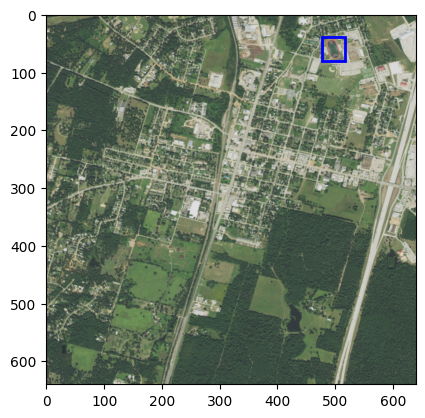

In [ ]:
idx = 2
sample = train_dataset[idx]
img = sample[0]
print(img.shape)
targets = sample[1]
bboxes = targets['boxes']
print(targets['labels'])
print(bboxes)
img = np.transpose(img.detach().numpy(),(1,2,0))#[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]

fig, ax = plt.subplots()

# Display the image
ax.imshow(img)
for box in bboxes.detach().numpy():
  if box[0] >= 0:
    ax.add_patch(bbox_to_rect(box, 'blue'))

In [ ]:
train_dataset[2]

{'boxes': tensor([[186., 518., 211., 554.]]), 'labels': tensor([2]), 'area': tensor([900.]), 'iscrowd': tensor([0]), 'image_id': tensor([2])}


(tensor([[[0.7451, 0.7412, 0.7255,  ..., 0.5922, 0.6353, 0.6078],
          [0.7412, 0.7255, 0.7059,  ..., 0.7059, 0.7216, 0.7333],
          [0.7255, 0.6980, 0.6588,  ..., 0.7176, 0.7255, 0.7294],
          ...,
          [0.4588, 0.4078, 0.3765,  ..., 0.5059, 0.5529, 0.5490],
          [0.4784, 0.4275, 0.4471,  ..., 0.5373, 0.6196, 0.5922],
          [0.4784, 0.4314, 0.4745,  ..., 0.5961, 0.6039, 0.5137]],
 
         [[0.7608, 0.7529, 0.7373,  ..., 0.5961, 0.6588, 0.6431],
          [0.7569, 0.7412, 0.7176,  ..., 0.7333, 0.7490, 0.7608],
          [0.7373, 0.7137, 0.6745,  ..., 0.7451, 0.7569, 0.7608],
          ...,
          [0.4941, 0.4353, 0.4157,  ..., 0.5373, 0.5922, 0.5922],
          [0.5059, 0.4667, 0.4784,  ..., 0.5725, 0.6549, 0.6353],
          [0.4980, 0.4588, 0.4941,  ..., 0.6275, 0.6353, 0.5569]],
 
         [[0.7294, 0.7255, 0.7059,  ..., 0.5765, 0.6392, 0.6314],
          [0.7255, 0.7059, 0.6824,  ..., 0.7255, 0.7451, 0.7569],
          [0.7059, 0.6745, 0.6392,  ...,

In [ ]:
def iou(y_true, y_pred):
  intsersection_x1 = np.maximum(y_true[0], y_pred[0])
  intsersection_x2 = np.minimum(y_true[2], y_pred[2])
  intsersection_y1 = np.maximum(y_true[1], y_pred[1])
  intsersection_y2 = np.minimum(y_true[3], y_pred[3])

  x_diff = np.maximum(intsersection_x2 - intsersection_x1 + 1, np.array(0.))
  y_diff = np.maximum(intsersection_y2 - intsersection_y1 + 1, np.array(0.))

  intersection = x_diff * y_diff

  true_x = y_true[2] - y_true[0] + 1
  true_y = y_true[3] - y_true[1] + 1

  pred_x = y_pred[2] - y_pred[0] + 1
  pred_y = y_pred[3] - y_pred[1] + 1

  union = true_x * true_y + pred_x * pred_y - intersection

  return intersection / union

In [ ]:
from collections import defaultdict

In [ ]:
def multi_iou(y_true, y_pred):
  canvas = np.zeros(640*640).reshape([640,640])
  true_canvas = canvas.copy()
  for t in y_true:
    true_canvas = cv2.rectangle(true_canvas,
                                (int(t[0]),int(t[1])),
                                (int(t[2]),int(t[3])),
                                1,
                                -1)
  pred_canvas = canvas.copy()
  for p in y_pred:
    pred_canvas = cv2.rectangle(pred_canvas,
                                (int(p[0]),int(p[1])),
                                (int(p[2]),int(p[3])),
                                2,
                                -1)
  actual = np.matrix(true_canvas)
  predictions = np.matrix(pred_canvas)
  combined = np.squeeze(np.asarray(actual + predictions))

  unique, counts = np.unique(combined, return_counts=True)
  mapping = defaultdict(lambda: 0, zip(unique, counts))

  TN = mapping[0]
  FN = mapping[1]
  FP = mapping[2]
  TP = mapping[3]

  added = 0

  if len(y_pred) == 0:
    return -1,-1,-1

  if (TP + FN) == 0 or (TP + FP) == 0:
    added += 1
  iou = float(TP) / float((FN + FP + TP + added))
  precision = float(TP) / float((TP + FP + added))
  recall = float(TP) / float((TP + FN + added))

  return iou, precision, recall

In [ ]:
import torchvision
from torch.nn import Identity

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=False, trainable_backbone_layers=5)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

model = create_model(4).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/detection/backbone_utils.py:160: UserWarning: Changing trainable_backbone_layers has not effect if neither pretrained nor pretrained_backbone have been set to True, falling back to trainable_backbone_layers=5 so that all layers are trainable
  warnings.warn(


In [ ]:
def read_data(X):
  images = list(image.cuda() for image in X[0])
  targets = [{k: v.cuda() for k, v in t.items()} for t in X[1]]
  return images, targets
# For Training
model.train()
X = next(iter(train_loader))
images, targets = read_data(X)
output = model(images,targets)   # Returns losses and detections
#print(output)
model.eval()
train_preds = model(images)
for i in range(len(train_preds)):
  num_true_boxes = len(targets[i]['boxes'])

  multi_iou(targets[i]['boxes'][0:num_true_boxes], 
            train_preds[i]['boxes'][0:num_true_boxes])


OutOfMemoryError: ignored

In [ ]:
for i in range(len(train_preds)):
  num_true_boxes = len(targets[i]['boxes'])

  multi_iou(targets[i]['boxes'][0:num_true_boxes], 
            train_preds[i]['boxes'][0:num_true_boxes])

tensor([0.3850, 0.0100, 0.4467, 0.1017], device='cuda:0')
{0.0: 357872, 1.0: 2128}
{0.0: 360000}
{0.0: 360000}
tensor([0.7283, 0.1067, 1.3917, 0.1867], device='cuda:0')
{0.0: 352013, 1.0: 7987}
{0.0: 360000}
tensor([0.1033, 0.2233, 0.6800, 0.7767], device='cuda:0')
{0.0: 244449, 1.0: 115551}
tensor([0.5700, 0.0750, 0.6200, 0.1500], device='cuda:0')
{0.0: 358574, 1.0: 1426}
tensor([ 0.9067, -0.0983,  1.1250,  0.1433], device='cuda:0')
{0.0: 355128, 1.0: 4872}
tensor([0.8017, 0.3217, 1.0000, 1.0000], device='cuda:0')
{0.0: 311567, 1.0: 48433}
{0.0: 360000}
tensor([0.2600, 0.8567, 0.4833, 0.8867], device='cuda:0')
{0.0: 357435, 1.0: 2565}
tensor([0.0000, 0.4400, 0.6167, 1.0000], device='cuda:0')
{0.0: 235344, 1.0: 124656}
tensor([0.5017, 0.3833, 1.0000, 0.9733], device='cuda:0')
{0.0: 253855, 1.0: 106145}
tensor([0.1533, 0.8767, 0.2233, 0.9417], device='cuda:0')
tensor([0.1483, 0.8633, 0.3033, 0.9733], device='cuda:0')
{0.0: 353635, 1.0: 6365}
tensor([0.2167, 0.8583, 0.2583, 0.9183], devi

In [ ]:
model.eval()
model.cuda()
images = [t.cuda() for t in images]
model(images)

NameError: ignored

In [ ]:
model.to('cuda')
print('')

In [ ]:
# model = torchvision.models.resnet50()
# req_layers = list(model.children())[:8]
# backbone = nn.Sequential(*req_layers)
# out = backbone(torch.unsqueeze(train_dataset[0][0], 0))

In [ ]:
# model = torchvision.models.resnet50()
# for p in backbone.named_parameters():
#   print(p[1].requires_grad)

In [ ]:
# out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [ ]:
from torchvision import ops

In [ ]:
!mv /content/drive/MyDrive/utils.py /content/

mv: cannot stat '/content/drive/MyDrive/utils.py': No such file or directory


In [ ]:
import torch.nn.functional as F

In [ ]:
model = torchvision.models.resnet50()
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)
out = backbone(torch.unsqueeze(train_dataset[0][0], 0))
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
dummy_img = torch.zeros((1, 3, 600, 600)).float()
print(out_c)
print(out_h)
print(out_w)
out_map = backbone(dummy_img)
print(out_map.size())

2048
19
19
torch.Size([1, 2048, 19, 19])


In [ ]:
def read_data(X):
  images = list(image.cuda() for image in X[0])
  targets = [{k: v.cuda() for k, v in t.items()} for t in X[1]]
  return images, targets

In [ ]:
from engine import evaluate

In [ ]:
def train(model, train_loader, val_loader, epochs=300, lr=0.1):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs*0.5),int(epochs*0.75)], gamma=0.1)
  # loss_fn = nn.CrossEntropyLoss()
  classLossFunc = nn.CrossEntropyLoss()
  bboxLossFunc = nn.MSELoss()
  training_data = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train IOU', 'Train Precision'
                                        'Train Recall', 'Val Loss', 'Val IOU', 'Val Precision', 'Val Recall'])
  for e in range(epochs):
    model.train()
    tbar = tqdm(train_loader, position=0, leave=True)
    
    start = time.time()
    train_loss_temp = []
    train_iou_temp = []
    train_precision_temp = []
    train_recall_temp = []

    correct = 0
    total = 0
    for batch, (X) in enumerate(tbar):
      model.train()
      img, y_true = read_data(X)

      optimizer.zero_grad()
      loss = model(img, y_true)
      losses = sum(loss for loss in loss.values())
      losses.backward()
      optimizer.step()

      loss_history = losses.item()

      train_loss_temp.append(loss_history)


      model.eval()
      train_preds = model(img)
      iou = 0.0
      recall = 0.0
      precision = 0.0
      total_count = 0
      for i in range(len(train_preds)):
        num_true_boxes = len(y_true[i]['boxes'])
        if num_true_boxes > 0:
          temp_iou, temp_precision, temp_recall = multi_iou(y_true[i]['boxes'][0:num_true_boxes], 
                    train_preds[i]['boxes'][0:num_true_boxes])
          
          if temp_iou >= 0:
            iou += temp_iou
            recall += temp_recall
            precision += temp_precision
            total_count += 1

      if total_count > 0:
        iou /= total_count
        recall /= total_count
        precision /= total_count

      train_iou_temp.append(iou)
      train_precision_temp.append(precision)
      train_recall_temp.append(recall)

      tbar.set_description('Epoch: %i, Loss: %f, IoU: %f, Precision: %f, Recall: %f' % (e+1, np.round(np.mean(train_loss_temp),4),
                                                                                        np.round(np.mean(train_iou_temp),4),
                                                                                        np.round(np.mean(train_precision_temp),4),
                                                                                        np.round(np.mean(train_recall_temp),4)))

    model.eval()
    vbar = tqdm(val_loader, position=0, leave=True)
    val_loss_temp = []
    val_iou_temp = []
    val_precision_temp = []
    val_recall_temp = []
    with torch.no_grad():
      for batch, (X) in enumerate(vbar):
        img, y_true = read_data(X)

        y_preds = model(img, y_true)

        iou = 0.0
        recall = 0.0
        precision = 0.0
        total_count = 0
        for i in range(len(y_preds)):
          num_true_boxes = len(y_true[i]['boxes'])
          if num_true_boxes > 0:
            temp_iou, temp_precision, temp_recall = multi_iou(y_true[i]['boxes'][0:num_true_boxes], 
                      y_preds[i]['boxes'][0:num_true_boxes])
            
            if temp_iou >= 0:
              iou += temp_iou
              recall += temp_recall
              precision += temp_precision
              total_count += 1

        if total_count > 0:
          iou /= total_count
          recall /= total_count
          precision /= total_count
          

        val_iou_temp.append(iou)
        val_precision_temp.append(precision)
        val_recall_temp.append(recall)

        #losses = sum(loss for loss in loss.values())

        #loss_history = losses.item()

        #val_loss_temp.append(loss_history)

        vbar.set_description('Epoch: %i, Val IoU: %f, Val Precision: %f, Val Recall: %f' % (e+1,
                                                                                            np.round(np.mean(val_iou_temp),4),
                                                                                            np.round(np.mean(val_precision_temp),4),
                                                                                            np.round(np.mean(val_recall_temp),4)))
    evaluate(model, val_loader, 'cuda')
    end = time.time()
    training_data.at[e, 'Epoch'] = e+1
    training_data.at[e, 'Train Loss'] = np.round(np.mean(train_loss_temp),4)
    training_data.at[e, 'Train IOU'] = np.round(np.mean(train_iou_temp),4)
    training_data.at[e, 'Train Precision'] = np.round(np.mean(train_precision_temp),4)
    training_data.at[e, 'Train Recall'] = np.round(np.mean(train_recall_temp),4)
    training_data.at[e, 'Val Loss'] = np.round(np.mean(val_loss_temp),4)
    training_data.at[e, 'Val IOU'] = np.round(np.mean(val_iou_temp),4)
    training_data.at[e, 'Val Precision'] = np.round(np.mean(val_precision_temp),4)
    training_data.at[e, 'Val Recall'] = np.round(np.mean(val_recall_temp),4)
    scheduler.step()

  return training_data

In [26]:
training_data = train(model, train_loader, val_loader, epochs=300, lr=0.005)

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:05  model_time: 0.1305 (0.1305)  evaluator_time: 0.0191 (0.0191)  time: 0.1669  data: 0.0083  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1295 (0.1297)  evaluator_time: 0.0161 (0.0157)  time: 0.1629  data: 0.0092  max mem: 27678
Test: Total time: 0:00:05 (0.1637 s / it)
Averaged stats: model_time: 0.1295 (0.1297)  evaluator_time: 0.0161 (0.0157)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:07  model_time: 0.1310 (0.1310)  evaluator_time: 0.0654 (0.0654)  time: 0.2140  data: 0.0083  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1298 (0.1300)  evaluator_time: 0.0144 (0.0162)  time: 0.1653  data: 0.0101  max mem: 27678
Test: Total time: 0:00:05 (0.1656 s / it)
Averaged stats: model_time: 0.1298 (0.1300)  evaluator_time: 0.0144 (0.0162)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:05  model_time: 0.1301 (0.1301)  evaluator_time: 0.0136 (0.0136)  time: 0.1616  data: 0.0088  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1299 (0.1300)  evaluator_time: 0.0149 (0.0162)  time: 0.1651  data: 0.0101  max mem: 27678
Test: Total time: 0:00:05 (0.1654 s / it)
Averaged stats: model_time: 0.1299 (0.1300)  evaluator_time: 0.0149 (0.0162)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:05  model_time: 0.1301 (0.1301)  evaluator_time: 0.0058 (0.0058)  time: 0.1535  data: 0.0084  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1296 (0.1299)  evaluator_time: 0.0142 (0.0156)  time: 0.1648  data: 0.0100  max mem: 27678
Test: Total time: 0:00:05 (0.1646 s / it)
Averaged stats: model_time: 0.1296 (0.1299)  evaluator_time: 0.0142 (0.0156)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:05  model_time: 0.1293 (0.1293)  evaluator_time: 0.0135 (0.0135)  time: 0.1604  data: 0.0084  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1302 (0.1302)  evaluator_time: 0.0154 (0.0185)  time: 0.1693  data: 0.0105  max mem: 27678
Test: Total time: 0:00:05 (0.1679 s / it)
Averaged stats: model_time: 0.1302 (0.1302)  evaluator_time: 0.0154 (0.0185)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:06  model_time: 0.1298 (0.1298)  evaluator_time: 0.0440 (0.0440)  time: 0.1915  data: 0.0086  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1298 (0.1301)  evaluator_time: 0.0188 (0.0179)  time: 0.1691  data: 0.0092  max mem: 27678
Test: Total time: 0:00:05 (0.1665 s / it)
Averaged stats: model_time: 0.1298 (0.1301)  evaluator_time: 0.0188 (0.0179)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:06  model_time: 0.1292 (0.1292)  evaluator_time: 0.0290 (0.0290)  time: 0.1750  data: 0.0078  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1304 (0.1305)  evaluator_time: 0.0140 (0.0176)  time: 0.1660  data: 0.0095  max mem: 27678
Test: Total time: 0:00:05 (0.1670 s / it)
Averaged stats: model_time: 0.1304 (0.1305)  evaluator_time: 0.0140 (0.0176)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:05  model_time: 0.1303 (0.1303)  evaluator_time: 0.0127 (0.0127)  time: 0.1606  data: 0.0083  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1302 (0.1304)  evaluator_time: 0.0137 (0.0167)  time: 0.1648  data: 0.0095  max mem: 27678
Test: Total time: 0:00:05 (0.1657 s / it)
Averaged stats: model_time: 0.1302 (0.1304)  evaluator_time: 0.0137 (0.0167)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:05  model_time: 0.1354 (0.1354)  evaluator_time: 0.0096 (0.0096)  time: 0.1634  data: 0.0090  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1300 (0.1304)  evaluator_time: 0.0160 (0.0173)  time: 0.1724  data: 0.0150  max mem: 27678
Test: Total time: 0:00:05 (0.1699 s / it)
Averaged stats: model_time: 0.1300 (0.1304)  evaluator_time: 0.0160 (0.0173)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:06  model_time: 0.1306 (0.1306)  evaluator_time: 0.0279 (0.0279)  time: 0.1766  data: 0.0089  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1300 (0.1300)  evaluator_time: 0.0158 (0.0181)  time: 0.1688  data: 0.0099  max mem: 27678
Test: Total time: 0:00:05 (0.1675 s / it)
Averaged stats: model_time: 0.1300 (0.1300)  evaluator_time: 0.0158 (0.0181)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:05  model_time: 0.1296 (0.1296)  evaluator_time: 0.0044 (0.0044)  time: 0.1515  data: 0.0085  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1301 (0.1301)  evaluator_time: 0.0189 (0.0170)  time: 0.1686  data: 0.0102  max mem: 27678
Test: Total time: 0:00:05 (0.1663 s / it)
Averaged stats: model_time: 0.1301 (0.1301)  evaluator_time: 0.0189 (0.0170)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ Io

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

creating index...
index created!
Test:  [ 0/35]  eta: 0:00:05  model_time: 0.1303 (0.1303)  evaluator_time: 0.0103 (0.0103)  time: 0.1580  data: 0.0082  max mem: 27678
Test:  [34/35]  eta: 0:00:00  model_time: 0.1301 (0.1300)  evaluator_time: 0.0151 (0.0158)  time: 0.1657  data: 0.0098  max mem: 27678
Test: Total time: 0:00:05 (0.1646 s / it)
Averaged stats: model_time: 0.1301 (0.1300)  evaluator_time: 0.0151 (0.0158)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ Io

In [27]:
!mkdir /content/drive/MyDrive/ATMLModels
torch.save(model.state_dict(), '/content/drive/MyDrive/ATMLModels/RCNN_FPN.pt')

mkdir: cannot create directory ‘/content/drive/MyDrive/ATMLModels’: File exists


In [28]:
!mkdir /content/drive/MyDrive/ATMLResults
training_data.to_csv('/content/drive/MyDrive/ATMLResults/RCNN_FPN_RESULTS.csv')